In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions
from pyspark.sql.types import *
from pyspark.sql.functions import *

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Create a SparkSession
spark = SparkSession.builder.appName("downsampling").getOrCreate()

## Random Sample valid user id 

In [ ]:
valid_user_id = pd.read_csv('../data/valid_user_id.csv')

In [ ]:
valid_user_id.info()

In [ ]:
lines = spark.sparkContext.textFile("../data/all_play.log.fn")

In [ ]:
def parseLine(line):
    """Parse lines from large text file and save it to Row RDD
    
    TODO: write these parseLine into a class. The chosen_uid argument can be object attribute
    """
    fields = line.split('\t')
    if len(fields) == 10:
        try:
            uid = float(fields[0])
            device = str(fields[1])
            song_id = str(fields[2])
            song_type = float(fields[3])
            song_name = str(fields[4])
            singer = str(fields[5])
            play_time = str(fields[6])
            song_length = float(fields[7])
            paid_flag = float(fields[8])
            fn = str(fields[9])
            return Row(uid, device, song_id, song_type, song_name, singer, play_time, song_length, paid_flag, fn)
        except:
            return Row(None)
    else:
        return Row(None)


schema = StructType([StructField('uid', FloatType(), False),
                     StructField('device', StringType(), True),
                     StructField('song_id', StringType(), False),
                     StructField('song_type', FloatType(), True),
                     StructField('song_name', StringType(), True),
                     StructField('singer', StringType(), True),
                     StructField('play_time', StringType(), False),
                     StructField('song_length', FloatType(), True),
                     StructField('paid_flag', FloatType(), True),
                     StructField('fn', StringType(), True),])

## Filter User ID (remove test uid) and drop uninformative columns

In [ ]:
songs = lines.map(parseLine).filter(lambda x: len(x) == len(schema))
# Convert that to a DataFrame
df_all_valid = spark.createDataFrame(songs,schema)
df_all_valid = df_all_valid.drop('song_type',
                                     'song_name', 
                                     'singer',
                                     'paid_flag').filter(df_all_valid['uid'].isin(list(valid_user_id.uid.values)))

## Transform file_name to datatime
* search log and download log start from 2017-3-30
* no playlog from 3-10 to 3-28

In [ ]:
df_all_valid = df_all_valid.withColumn("device", trim(df_all_valid.device)) \
                               .withColumn('date_str', trim(df_all_valid.fn.substr(1,9))) \
                               .withColumn('date_string', regexp_replace('date_str', '20170339', '20170329')) \
                               .withColumn("unix_date", unix_timestamp('date_string', 'yyyyMMdd')) \
                               .withColumn("date", from_unixtime('unix_date').cast(DateType())) \
                               .drop('date_str') \
                               .drop('date_string') \
                               .drop('unix_date').cache()

In [ ]:
pd.DataFrame(df_all_valid.take(5), columns=df_all_valid.columns)

### How many records we get per day?

In [ ]:
df_date_count = df_all_valid.groupby('date').count().toPandas()

In [ ]:
plt.figure(figsize = (10,6))
plt.bar(df_date_count.date.values, df_date_count.index.values)
plt.title("total count of playlog record per day")
plt.xlabel('date')
plt.ylabel('count')
plt.savefig('count_per_day')

### When is the first play record for each user?
* we shouldn't consider the users who starts using the app after 2017-04-29, they're not churned nor active

In [20]:
df_firstday = df_all_valid.groupby('uid') \
                            .agg({ 'date': 'min'}).toPandas()

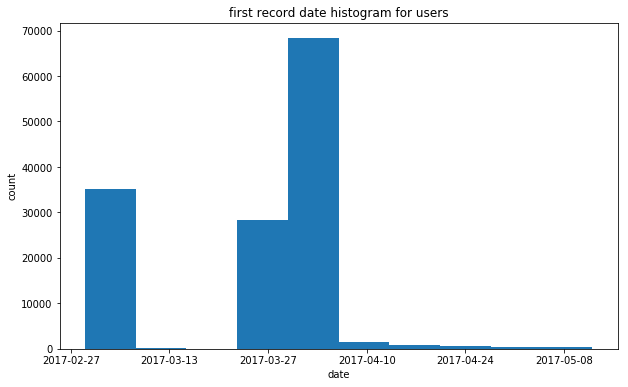

In [24]:
plt.figure(figsize = (10,6))
plt.hist(df_firstday['min(date)'].values)
plt.title("first record date histogram for users")
plt.xlabel('date')
plt.ylabel('count')
plt.savefig('min_date')

### drop those who start after '2017-04-29'

In [30]:
user_to_choose = df_firstday[df_firstday['min(date)'].apply(pd.to_datetime) < pd.to_datetime('2017-04-29')].uid.values

In [60]:
user_to_choose.shape

(134794,)

In [ ]:
# play log dated from 20170301 to 20170512, 
# use last 2 week as churn window 
print(user_to_choose.shape)
#pd.DataFrame(df_all_valid.take(5), columns=df_all_valid.columns)

active_uid = df_all_valid.filter(df_all_valid.date >= '2017-04-29').select(df_all_valid.uid.alias('active_uid')).distinct()

#pd.DataFrame(active_uid.take(5), columns=active_uid.columns)
active_uid = active_uid.filter(active_uid.uid.isin(list(user_to_choose))
#active_uid.repartition(1).write.csv('../data/active_uid', header=True)
print('total number of active user is', active_uid.count())

In [ ]:
# converting spark dataframe column to list
active_list = active_uid.select('active_uid').rdd.flatMap(lambda x: x).collect()
valid_user_id['churn_label'] = valid_user_id['uid'].isin(active_list)

### Check the ratio of active and churned user

In [ ]:
valid_user_id.groupby('churn_label').count()

In [ ]:
valid_user_id.to_csv('../data/valid_user_id.csv', index=False)

## Down sample 1:1 in churned and active user

In [ ]:
# keep 5% of the valid user id for training and modeling
sampled_uid = valid_user_id.groupby('churn_label').apply(lambda x: x.sample(frac=0.05)).set_index('uid')
# we have 6777 sampled user in total

In [ ]:
sampled_playlog = df_all_valid.filter(df_all_valid['uid'].isin(list(sampled_uid.index.values))).cache()

In [ ]:
pd.DataFrame(sampled_playlog.take(5),columns=sampled_playlog.columns)

In [ ]:
sampled_playlog.coalesce(1).write.format('json').save('../data/sampled_playlog.json')

In [ ]:
df_sampled = pd.read_json('../data/sampled_playlog.json/part-00000-badae413-8a2b-46ea-9ce7-c83aaa3fa0f5-c000.json'
                          ,lines=True)

In [ ]:
df_sampled.head()

In [ ]:
spark.stop()